# Twitter Analysis with Rob Bishop

## Downloading, parsing, and analyzing data from one of the worlds largest sources of information

In [1]:
# ----- IMPORTS AND SETUP -----
# --- OUTPUT ---
from IPython.core import page
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
page.page = print 
# --- Analysis Packages ---
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
#---Twitter Packages---
import tweepy
#---Standard Packages---
import json
import time
import os
#---My Files---
import Tweet_Getter
import Tweet_Parser
import Tweet_Stats

## The structure of a tweet

Tweets are sent in the JSON format which converts natively into a python dictionary:

In [2]:
f = open("./tweets/example_tweet.txt","r+",encoding = "utf-8")
example_tweet = json.loads(f.readline())
f.close()
example_tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sat Oct 21 12:07:16 +0000 2017',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 44038,
 'favorited': False,
 'geo': None,
 'id': 921709468055896064,
 'id_str': '921709468055896064',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 10326,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'text': 'I hope the Fake News Media keeps talking about Wacky Congresswoman Wilson in that she, as a representative, is killing the Democrat Party!',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
  'default_profile': False,
  'default_profile_image': False,
  'description

**That's a lot of info!** And in various formats. But before we get ahead of ourselves, let's find a way to get some tweets...

## A Note on Twitter Apps

To access any of twitter's APIs you will need an account and tokens from https://apps.twitter.com/ This process has been omitted here for brevity.

# Tweepy

We will be using tweepy to grab the tweets. Tweepy is a wrapper for twitter's API and provides two main ways of gathering twitter information: using the search API and using a realtime stream API. Let's focus on the first one, in an attempt to grab as many tweets as we can from a single user:

In [3]:
%pycat Tweet_Getter.py

#---------- IMPORTS ----------
import os
import time
import configparser
import json
import tweepy

#---------- CFG ----------
TOKEN_FILENAME = "tokens.ini"

def Get_Tokens(filename=TOKEN_FILENAME):
    """Gets tokens from a local INI file and return them in a dict"""
    #if no token file is found create one with the appropriate paths
    if not os.path.isfile(filename):
        config_write = open(filename,"w+")
        config = configparser.ConfigParser()
        config.add_section("TOKENS")
        config.set("TOKENS","access_token","")
        config.set("TOKENS","access_token_secret","")
        config.set("TOKENS","consumer_key","")
        config.set("TOKENS","consumer_secret","")
        config.write(config_write)
        print("ERROR: file ", filename, " not found. It has been created in the working directory, please enter the appropriate token values")
        quit()
    #if the file exists get the token values from it
    config = configparser.ConfigParser()
    tokens = {}

Most of the implementation details above are specific to the tweepy and twitter API and so won't be discussed here. Essentially, we download every tweet the API will let us and write each as a JSON object to a new line in a plaintext output file. Twitter's API only lets you access the latest 3000 or so tweets, which amounts to roughly a 10mb file. 

**Let's run an example now:**

In [4]:
VIP_name = "@Oprah"
VIP_file_name = "./tweets/"+VIP_name+"_tweets.txt"
#----- UNCOMMENT BELOW TO RETRIEVE FILES LIVE -----
#Tweet_Getter.Get_All_Tweets_From_User(VIP_name,write_to_file = True, filename = VIP_file_name)
None

The tweets are now saved to a file on disk. Just to verify, let's grab the 10 most recent tweets and print their text:

In [5]:
f = open(VIP_file_name)
for n in range(10):
    tweet = json.loads(f.readline())
    print (tweet["text"]+"\n")

Essence exec turned B&amp;B mogul Monique Greenwood is redefining hospitality in @OWNTV's NEW series #CheckedInn! Tonig… https://t.co/mN13u90VBC

Here it is! The brand-new #WrinkleInTime trailer. See you in theaters, March 9th. With love, Mrs. Which 💜 https://t.co/RHia4jFXx3

NEW #WrinkleInTime trailer TONIGHT during the American Music Awards. Who’s ready to tesser with me!? 👋🏾 https://t.co/SB4lcZzqiw

Good morning, SuperSoulers! Dr. @BreneBrown shows how even when we fall, we can still RISE STRONG. So many tweetabl… https://t.co/yFL9vknbzb

Roderick became a hero. Thank you @IyanlaVanzant #FixMyLife

@IyanlaVanzant went to the foundation  of these souls to bring responsibility and healing. #FixMyLife

@IyanlaVanzant @OWNTV See you There.

.@IyanlaVanzant, you’ve done it AGAIN - healing for so many. #FixMyLife Season Finale TONIGHT at 9pm. https://t.co/XttPTu3Pod

RT @ava: Tessering into your timeline with our brand new poster for #WrinkleinTime! Otherworldly! And tune into @AMAs this 

## Parsing
We only want a select few bits of information from a tweet, so let's take only the data we want and import it into a pandas DataFrame:

First we feed in a list of headers. Note that these must match the tweet attributes exactly, or no data will be retrieved. An error will not be thrown as we are using the dictionary .get() method instead of directly accessing the keys.

We have written a few explicit exceptions into the method. First is the method that checks for retweets, as they are somewhat complex objects (a list of dictionaries contained within the entities attribute) and we are really only interested in the text itself.

We also check if the "created_at" attribute has been parsed. Neither pandas nor numpy autoconvert the string format of a tweet's date, but running pd.to_datetime() will convert the dates to pandas date objects, which can then be used for resampling and indexing.

We also check for the "retweeted_status" attribute. If the tweet is a retweet, it returns a copy of the tweet being retweeted. We don't have much use for this object, so instead we convert it to a boolean value that returns True if a tweet is a retweet. Retweeted tweets can't be favourited, so this is useful information. 

In [6]:
%pycat Tweet_Parser.py

"""Reads JSON tweets line by line from a file"""
#Tweet Parser contains functions to extract tweets from files on the HD
#---------- IMPORTS ----------
import json
import pandas as pd
#---------- FUNCTIONS ----------
def Get_Tweets_From_File(filename):
    """Returns a list of all tweets in a file. Tweets must be on seperate lines in the JSON format"""
    tweets = []
    file = open(filename,"r")
    for line in file:
        tweet = json.loads(line)
        tweets.append(tweet)
    print("Unpacked ",len(tweets)," tweets from ",filename)
    file.close()
    return tweets   

def Get_Only_Headers_From_File(filename,headers,get_hashtags = True):
    """Takes a filename and a list of attributes and returns a list of lists of those attributes in order"""
    #TODO: Have a boolean as to whether or not a tweet contains URLs or Media
    tweets = []
    file = open(filename,"r")
    for line in file:
        tweet = json.loads(line)
        cleaned_tweet = []
        for attribute in header

In [7]:
headers = ["created_at","coordinates","retweet_count","favorite_count","retweeted_status","text","hashtags"]
VIP_tweets = Tweet_Parser.Get_Panda_Dataframe_From_File(VIP_file_name,headers,offset_time = True)

## VIP Numeric Analysis

In [8]:
#because everyone wants to know: which tweets are the most retweeted?
VIP_tweets.sort_values("retweet_count",ascending=False).head()

,coordinates,retweet_count,favorite_count,retweeted_status,text,hashtags
created_at,,,,,,
2015-04-24 23:39:07,None,37605,63061,False,"""All of us deserve the right to be loved for w...",[BruceJenner]
2017-09-16 20:30:06,None,27890,81697,False,@,None
2016-06-06 09:39:00,None,16069,0,True,"RT @FLOTUS: Together, we are stronger. Togethe...",[StateOfWomen]
2016-09-26 20:04:00,None,13387,30119,False,"""Just listen to what you heard"" best advice of...",[debatenight]
2016-04-21 12:49:01,None,11749,28352,False,Prince the doves really are crying now. Listen...,[RIPPrince]


In [9]:
VIP_tweets.describe()

,retweet_count,favorite_count
count,3225.000000,3225.000000
mean,301.662636,786.029147
std,1129.587464,2778.563012
min,0.000000,0.000000
25%,17.000000,27.000000
50%,93.000000,133.000000
75%,265.000000,668.000000
max,37605.000000,81697.000000


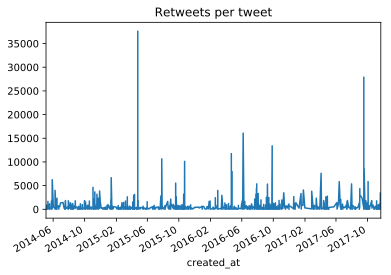

In [10]:
VIP_tweets["retweet_count"].plot(title="Retweets per tweet")
None

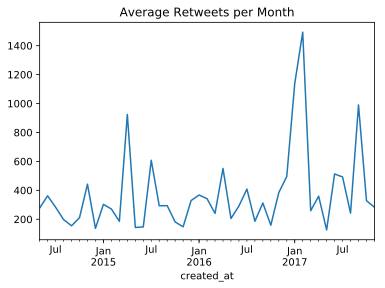

In [11]:
VIP_tweets["retweet_count"].resample("M").mean().plot(title="Average Retweets per Month")
None

created_at  created_at
2014        5             140
            6              59
            7              49
            8              81
            9             159
            10            127
            11             90
            12            117
2015        1              69
            2              93
            3             128
            4              87
            5              71
            6              37
            7              30
            8              28
            9              97
            10            264
            11             51
            12             11
2016        1              23
            2              40
            3              52
            4              58
            5              37
            6             124
            7             105
            8             156
            9             167
            10            149
            11             38
            12             19
2017        1    

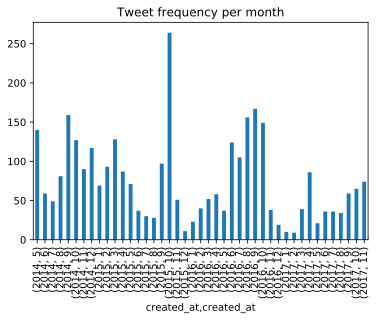

In [12]:
VIP_tweets.groupby([VIP_tweets.index.year,VIP_tweets.index.month]).size().plot(title="Tweet frequency per month",kind="bar")
VIP_tweets.groupby([VIP_tweets.index.year,VIP_tweets.index.month]).size()

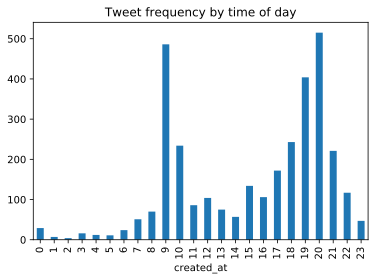

In [13]:
VIP_tweets.groupby(VIP_tweets.index.hour).size().plot(kind="bar",title="Tweet frequency by time of day")
None

# Text Analysis

More interestingly than the numeric analysis is an analysis of the text contained within a tweet.

In [14]:
%pycat Tweet_Stats.py

"""Contains methods used to generate stasticics about tweets"""
#---------- IMPORTS ----------
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import heapdict
import html
#---------- CONSTANTS ----------
STOPWORDS = set(stopwords.words('english'))

#---------- FUNCTIONS ----------
# Note that these functions are generalized and very redundant with eachother
# Once you know what datasets you'd like and in what form, consider writing your own functions to extract that data

def Get_Most_Used_Words(tweet_text, n):
    """Returns a list of the n most frequently used words"""
    #NOTE: Python only has support for a minheap so all the values are inverted until they are returned
    freq = heapdict.heapdict()
    output = []
    #Get frequency of words in all tweets
    for line in tweet_text:
        for word in line:
            if word in freq:
                freq[word]-=1
            else:
                freq[word] = 1

## Removing Stop Words
A stop word is a word that only serves a grammatical function, like "the" "a" or "so". Using our remove_stopwords function we can eliminate the common stopwords from the NLTK as well as whatever words we pass in. This allows us to focus in on only the most "lexically interesting" terms for a word-by-word analysis of the tweets. Here is the raw text of the first few tweets:

In [15]:
VIP_tweets.text.head()

created_at
2017-11-21 18:12:23    Essence exec turned B&amp;B mogul Monique Gree...
2017-11-19 19:30:02    Here it is! The brand-new #WrinkleInTime trail...
2017-11-19 11:00:04    NEW #WrinkleInTime trailer TONIGHT during the ...
2017-11-19 10:03:48    Good morning, SuperSoulers! Dr. @BreneBrown sh...
2017-11-18 21:06:32    Roderick became a hero. Thank you @IyanlaVanza...
Name: text, dtype: object

And here is what they look like once the stopwords have been filtered. Note that the text has been replaced by a list containing the words, this makes doing a wordcount easier:

In [16]:
skip_words = ["rt"]
VIP_tweets.text = [Tweet_Stats.Remove_Stopwords(str(n),skip_words) for n in VIP_tweets.text]
VIP_tweets.text.head()

created_at
2017-11-21 18:12:23    [essence, exec, turned, b, b, mogul, monique, ...
2017-11-19 19:30:02    [brand, new, wrinkleintime, trailer, see, thea...
2017-11-19 11:00:04    [new, wrinkleintime, trailer, tonight, america...
2017-11-19 10:03:48    [good, morning, supersoulers, dr, brenebrown, ...
2017-11-18 21:06:32    [roderick, became, hero, thank, iyanlavanzant,...
Name: text, dtype: object

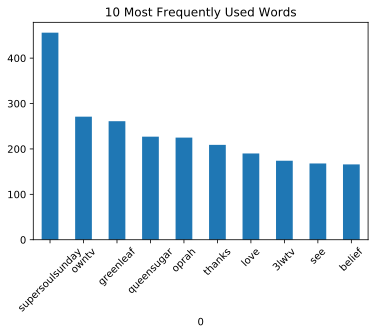

In [17]:
VIP_most_used = Tweet_Stats.Get_Most_Used_Words(VIP_tweets.text,10)
VIP_most_used = pd.DataFrame(VIP_most_used)
VIP_most_used.set_index(0,inplace = True)
VIP_most_used.plot(kind="bar",rot = 45,title="10 Most Frequently Used Words",legend=False)
None

### Now we can add a num_word column to the dataframe:

In [18]:
VIP_tweets["num_words"] = [len(words) for words in VIP_tweets.text ]
VIP_tweets.head()

,coordinates,retweet_count,favorite_count,retweeted_status,text,hashtags,num_words
created_at,,,,,,,
2017-11-21 18:12:23,None,183,958,False,"[essence, exec, turned, b, b, mogul, monique, ...",[CheckedInn],15
2017-11-19 19:30:02,None,3452,11870,False,"[brand, new, wrinkleintime, trailer, see, thea...",[WrinkleInTime],10
2017-11-19 11:00:04,None,395,2215,False,"[new, wrinkleintime, trailer, tonight, america...",[WrinkleInTime],9
2017-11-19 10:03:48,None,577,2118,False,"[good, morning, supersoulers, dr, brenebrown, ...",None,13
2017-11-18 21:06:32,None,86,896,False,"[roderick, became, hero, thank, iyanlavanzant,...",[FixMyLife],6


7.917519379844961

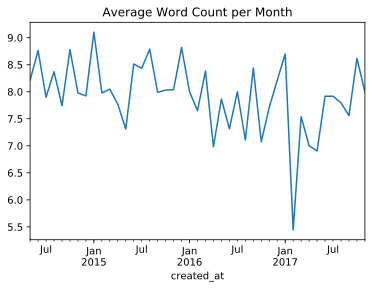

In [19]:
VIP_tweets.num_words.resample("M").mean().plot(title="Average Word Count per Month")
VIP_tweets.num_words.mean()

Pandas lets us check correlations fairly easily, is there a correlation between the number of words and the retweet count?

In [20]:
VIP_tweets.corr()

,retweet_count,favorite_count,retweeted_status,num_words
retweet_count,1.000000,0.819188,0.007815,0.034234
favorite_count,0.819188,1.000000,-0.110230,0.007911
retweeted_status,0.007815,-0.110230,1.000000,0.296935
num_words,0.034234,0.007911,0.296935,1.000000


With easy access to dates, facourite and retweet numbers, as well as the raw tokenized text of each tweet, we are prepared to make any number of queries we like.

# To close out, let's print out the 5 most used words and time-of-day frequency of some of twitter's top users:

In [21]:
headers = ["created_at","retweet_count","favorite_count","retweeted_status","text","hashtags"]
topusers = []
topusernames = []
for filename in os.listdir(os.getcwd()+"/tweets/topusers"):
    print ("retrieving ",filename)
    df = Tweet_Parser.Get_Panda_Dataframe_From_File(os.getcwd()+"/tweets/topusers/"+filename,headers)
    df.text = [Tweet_Stats.Remove_Stopwords(str(n),skip_words) for n in df.text]
    topusers.append(df)
    topusernames.append(filename[:-11])
    

retrieving  @elonmusk_tweets.txt
retrieving  @rihanna_tweets.txt
retrieving  @twitter_tweets.txt
retrieving  @BillGates_tweets.txt
retrieving  @justinbieber_tweets.txt
retrieving  @Oprah_tweets.txt
retrieving  @realDonaldTrump_tweets.txt
retrieving  @YouTube_tweets.txt
retrieving  @katyperry_tweets.txt
retrieving  @ladygaga_tweets.txt
retrieving  @Cristiano_tweets.txt
retrieving  @jtimberlake_tweets.txt


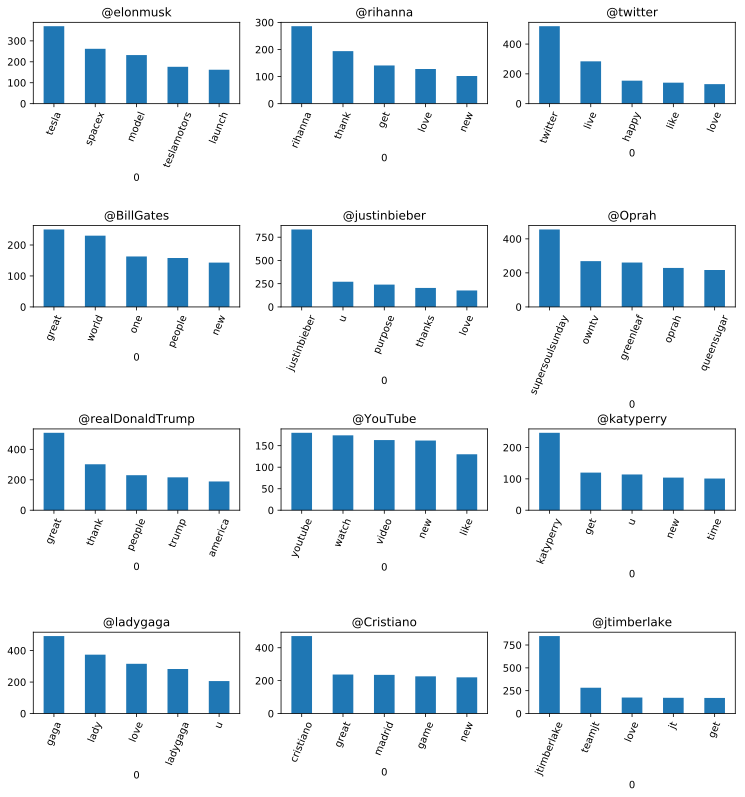

In [22]:
def plot_wordcount(df,n):
    most_used = Tweet_Stats.Get_Most_Used_Words(df.text,n)
    most_used = pd.DataFrame(most_used)
    most_used.set_index(0,inplace = True)
    return most_used
#Setup Subplots
fig, axes = plt.subplots(nrows=4, ncols=3)    
for i in range(4):
    for j in range(3):
        n = i*3+j
        axes[i,j].set_title(topusernames[n])
        topwords = `(topusers[n],5)
        topwords.plot(ax=axes[i,j],kind="bar",rot = 67.5,legend=False); axes[i,j];
            
plt.subplots_adjust(left=0.125, right = 1.75, bottom = 0.1, top = 2.5, wspace = 0.2,hspace = 1.5)
None

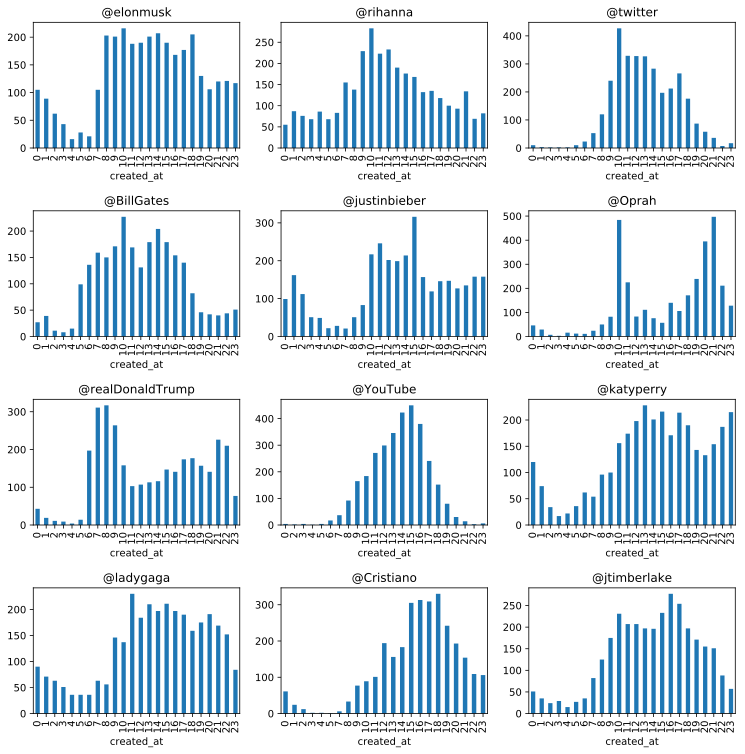

In [23]:
#VIP_tweets.groupby(VIP_tweets.index.hour).size().plot(kind="bar",title="Tweet frequency by time of day")
fig, axes = plt.subplots(nrows=4, ncols=3)    
for i in range(4):
    for j in range(3):
        n = i*3+j
        axes[i,j].set_title(topusernames[n])
        freqgraph = topusers[n].groupby(topusers[n].index.hour).size()
        freqgraph.plot(ax=axes[i,j],kind="bar",rot = 90,legend=False); axes[i,j];
        
plt.subplots_adjust(left=0.125, right = 1.75, bottom = 0.1, top = 2.5, wspace = 0.2,hspace = 0.5)    
None

# Conclusion
### The process and code presented here has shown a relatively simple but robust way of retrieving and analyzing twitter data.

In particular my key takeaway from this assignment for data analysis is:
* **Don't answer a question, create a framework that can answer any question** if you go in expecting to only solve one problem you will have to work much harder later on. I initially planned only to deal with text analysis, not numeric, and initially did not use pandas as a result, thinking I wouldn't need its numeric features.


* **Make your code extendable** following from the above, you may be required to change your code down the line in unexpected ways. Making every individual task a function, and using many constants are good code practices for a reason, as they make this kind of refactoring much easier.


* **Commit to parsing** at first I was hesitant to make commitments to changing the data, such as removing stopwords from the dataframe, or not storing the entire tweet object in the dataframe, but by making those things easy to retrieve and making the code simple enough to rewrite I felt comfortable making those commitments, and feel my code and output was much cleaner as a result, to the point where most of the graphs generated here post-parse were only a single line of code. 

### I will be posting the source code for the twitter retriever on github.com/zerocrossing once I finish the command line interface. It will include the ability to retrieve tweets in realtime which was omitted here for brevity.